In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Process

In [2]:
df_d = pd.read_csv("Dutch_new_all_session.csv")
df_h = pd.read_csv("Honolulu_rounded_and_accurate_all_session.csv")
df_d = df_d[df_d["subsession.round_number"] > 2]
df_h = df_h[df_h["subsession.round_number"] > 2]

In [3]:
dict_player_round = dict()
for index, row in df_d.iterrows():
    p_code = row["participant.code"]
    round = row["subsession.round_number"]
    if p_code not in dict_player_round:
        dict_player_round[p_code] = dict()
    dict_player_round[p_code][round] = {
        "d_item_value": row["player.item_value"],
        "d_bid_predict": row["predict.player.bid"],
        "d_dutch_price": row["group.dutch_final_price"],
        "d_dutch_predict": row["predict.player.is_dutch_winner"],
        "d_is_dutch_winner": row["player.is_dutch_winner"],
    }
for index, row in df_h.iterrows():
    p_code = row["participant.code"]
    round = row["subsession.round_number"]
    tmp_dict = {
        "h_start_price": row["session.config.start_price"],
        "h_item_value": row["player.item_value"],
        "h_bid_predict": row["predict.player.optimal_dutch_bid"],
        "h_dutch_price": row["group.dutch_final_price"],
        "h_dutch_predict": row["predict.player.is_dutch_winner"],
        "h_is_dutch_winner": row["player.is_dutch_winner"],
        "h_contest_predict": row["predict.player.contest_status"],
        "h_contest_status": row["player.contest_status"],
        "h_dropout_price": row["player.dropout_price"], 
        "h_english_predict": row["predict.player.is_english_winner"],
        "h_is_english_winner": row["player.is_english_winner"],
    }
    dict_player_round[p_code][round].update(tmp_dict)

In [4]:
dict_session = dict()
for index, row in df_d.iterrows():
    s_code = row["session.code"]
    p_code = row["participant.code"]
    s_type = row["session.config.name"]
    s_discount = row["session.config.discount_b"]
    if s_code not in dict_session:
        dict_session[s_code] = dict()
    if p_code not in dict_session[s_code]:
        dict_session[s_code][p_code] = {
            "session_type": s_type,
            "session_discount": s_discount,
            "d_n_dutch_irrational_bid": 0,
            "d_round_dutch_irrational_bid": [],
            "d_n_dutch_predicted_win": 0,
            "d_diff_dutch_predicted_win": [],
            "d_round_dutch_predicted_win": [],
            "d_n_dutch_predicted_lose": 0,
            "d_round_dutch_predicted_lose": [],
            "d_n_dutch_lucky_win": 0,
            "d_diff_dutch_lucky_win": [],
            "d_round_dutch_lucky_win": [],
            "d_n_dutch_greedy_lose": 0,
            "d_diff_dutch_greedy_lose": [],
            "d_round_dutch_greedy_lose": [],
            "h_n_dutch_irrational_bid": 0,
            "h_round_dutch_irrational_bid": [],
            "h_n_dutch_predicted_win": 0,
            "h_diff_dutch_predicted_win": [],
            "h_round_dutch_predicted_win": [],
            "h_n_dutch_predicted_lose": 0,
            "h_round_dutch_predicted_lose": [],
            "h_n_dutch_lucky_win": 0,
            "h_diff_dutch_lucky_win": [],
            "h_round_dutch_lucky_win": [],
            "h_n_dutch_greedy_lose": 0,
            "h_diff_dutch_greedy_lose": [],
            "h_round_dutch_greedy_lose": [],
            "h_n_contest_correct_bid": 0,
            "h_round_contest_correct_bid": [],
            "h_n_contest_correct_leave": 0,
            "h_round_contest_correct_leave": [],
            "h_n_contest_irrational": 0,
            "h_round_contest_irrational": [],
            "h_n_contest_regret": 0,
            "h_diff_contest_regret": [],
            "h_round_contest_regret": [],
            "h_n_english_irrational": 0,
            "h_diff_english_irrational": [],
            "h_round_english_irrational": [],
            "h_n_english_correct": 0,
            "h_diff_english_correct": [],
            "h_round_english_correct": [],
        }

for s_code in dict_session.keys():
    for p_code in dict_session[s_code].keys():
        for round in dict_player_round[p_code].keys():
            tmp_dict = dict_player_round[p_code][round]

            # process dutch data
            d_dutch_diff = tmp_dict["d_bid_predict"] - tmp_dict["d_dutch_price"]
            if tmp_dict["d_is_dutch_winner"]:
                # winning with negative payoff
                if (tmp_dict["d_item_value"] < tmp_dict["d_dutch_price"]):
                    dict_session[s_code][p_code]["d_n_dutch_irrational_bid"] += 1
                    dict_session[s_code][p_code]["d_round_dutch_irrational_bid"].append(round)
                else:
                    # winning as predicted
                    if tmp_dict["d_dutch_predict"]:
                        dict_session[s_code][p_code]["d_n_dutch_predicted_win"] += 1                                                                                                                                                                                                 
                        dict_session[s_code][p_code]["d_diff_dutch_predicted_win"].append(d_dutch_diff)
                        dict_session[s_code][p_code]["d_round_dutch_predicted_win"].append(round)
                    # winning becuase predicted winner waited for too long or himself overbid
                    else:
                        dict_session[s_code][p_code]["d_n_dutch_lucky_win"] += 1
                        dict_session[s_code][p_code]["d_diff_dutch_lucky_win"].append(d_dutch_diff)
                        dict_session[s_code][p_code]["d_round_dutch_lucky_win"].append(round)
            else:
                # losing because of waitting for too long
                if (tmp_dict["d_dutch_price"] < tmp_dict["d_bid_predict"]):
                    dict_session[s_code][p_code]["d_n_dutch_greedy_lose"] += 1
                    dict_session[s_code][p_code]["d_diff_dutch_greedy_lose"].append(d_dutch_diff)
                    dict_session[s_code][p_code]["d_round_dutch_greedy_lose"].append(round)
                # losing because of low item value
                else:
                    dict_session[s_code][p_code]["d_n_dutch_predicted_lose"] += 1
                    dict_session[s_code][p_code]["d_round_dutch_predicted_lose"].append(round)
            
            # process honolulu data
            h_dutch_diff = tmp_dict["h_bid_predict"] - tmp_dict["h_dutch_price"]
            if tmp_dict["h_is_dutch_winner"]:
                # winning with negative payoff
                if (tmp_dict["h_item_value"] < tmp_dict["h_dutch_price"]):
                    dict_session[s_code][p_code]["h_n_dutch_irrational_bid"] += 1
                    dict_session[s_code][p_code]["h_round_dutch_irrational_bid"].append(round)
                else:
                    # winning as predicted
                    if tmp_dict["h_dutch_predict"]:
                        dict_session[s_code][p_code]["h_n_dutch_predicted_win"] += 1
                        dict_session[s_code][p_code]["h_diff_dutch_predicted_win"].append(h_dutch_diff)
                        dict_session[s_code][p_code]["h_round_dutch_predicted_win"].append(round)
                    # winning becuase predicted winner waited for too long or himself overbid
                    else:
                        dict_session[s_code][p_code]["h_n_dutch_lucky_win"] += 1
                        dict_session[s_code][p_code]["h_diff_dutch_lucky_win"].append(h_dutch_diff)
                        dict_session[s_code][p_code]["h_round_dutch_lucky_win"].append(round)
            else:
                # losing because of waitting for too long
                if (tmp_dict["h_dutch_price"] < tmp_dict["h_bid_predict"]):
                    dict_session[s_code][p_code]["h_n_dutch_greedy_lose"] += 1
                    dict_session[s_code][p_code]["h_diff_dutch_greedy_lose"].append(h_dutch_diff)
                    dict_session[s_code][p_code]["h_round_dutch_greedy_lose"].append(round)
                # losing because of low item value
                else:
                    dict_session[s_code][p_code]["h_n_dutch_predicted_lose"] += 1
                    dict_session[s_code][p_code]["h_round_dutch_predicted_lose"].append(round)
            
            h_contest_diff = tmp_dict["h_item_value"] - tmp_dict["h_dutch_price"]
            if (tmp_dict["h_contest_status"] == 1) ^ (tmp_dict["h_item_value"] <= tmp_dict["h_dutch_price"]):
                # join contest when item value was higher than current price
                if tmp_dict["h_contest_status"] == 1:
                    dict_session[s_code][p_code]["h_n_contest_correct_bid"] += 1
                    dict_session[s_code][p_code]["h_round_contest_correct_bid"].append(round)
                # leave contest when item value was lower than current price
                else:
                    dict_session[s_code][p_code]["h_n_contest_correct_leave"] += 1
                    dict_session[s_code][p_code]["h_round_contest_correct_leave"].append(round)
            else:
                # join contest when item value was already lower than current price
                if tmp_dict["h_contest_status"] == 1:
                    dict_session[s_code][p_code]["h_n_contest_irrational"] += 1
                    dict_session[s_code][p_code]["h_round_contest_irrational"].append(round)
                # leave contest when item value was still higher than current price
                else:
                    dict_session[s_code][p_code]["h_n_contest_regret"] += 1
                    dict_session[s_code][p_code]["h_diff_contest_regret"].append(h_contest_diff)
                    dict_session[s_code][p_code]["h_round_contest_regret"].append(round)

            h_english_diff = tmp_dict["h_item_value"] - tmp_dict["h_dropout_price"]
            if tmp_dict["h_contest_status"] == 1:
                # leave too late
                if tmp_dict["h_dropout_price"] > tmp_dict["h_item_value"]:
                    dict_session[s_code][p_code]["h_n_english_irrational"] += 1
                    dict_session[s_code][p_code]["h_diff_english_irrational"].append(h_english_diff)
                    dict_session[s_code][p_code]["h_round_english_irrational"].append(round)
                # leave correctly or earlier
                else:
                    dict_session[s_code][p_code]["h_n_english_correct"] += 1
                    dict_session[s_code][p_code]["h_diff_english_correct"].append(h_english_diff)
                    dict_session[s_code][p_code]["h_round_english_correct"].append(round)

In [5]:
df_out = pd.DataFrame()
for s_code in dict_session.keys():
    tmp_df = pd.DataFrame(dict_session[s_code]).T
    tmp_df.insert(0, "session.code", s_code)
    tmp_df.insert(1, "participant.code", tmp_df.index)
    df_out = pd.concat([df_out, tmp_df], ignore_index=True)
df_out.to_csv("Individual behaviour.csv", header=True, index=False)

### Statistics

In [6]:
df_stat = pd.DataFrame()
df_stat["session.code"] = df_out["session.code"]
df_stat["participant.code"] = df_out["participant.code"]
df_stat["session_type"] = df_out["session_type"]
df_stat["session_discount"] = df_out["session_discount"]

In [7]:
df_stat["d_n_total"] = (
    df_out["d_n_dutch_irrational_bid"] 
    + df_out["d_n_dutch_predicted_win"] 
    + df_out["d_n_dutch_predicted_lose"] 
    + df_out["d_n_dutch_lucky_win"]
    + df_out["d_n_dutch_greedy_lose"]
)
df_stat["d_n_rational"] = (
    df_out["d_n_dutch_predicted_win"] 
    + df_out["d_n_dutch_predicted_lose"] 
    + df_out["d_n_dutch_lucky_win"]
)
df_stat["d_n_predicted_win"] = df_out["d_n_dutch_predicted_win"]
df_stat["d_meddiff_predicted_win"] = df_out["d_diff_dutch_predicted_win"].map(np.median)
df_stat["d_n_lucky_win"] = df_out["d_n_dutch_lucky_win"]
df_stat["d_meddiff_lucky_win"] = df_out["d_diff_dutch_lucky_win"].map(np.median)
df_stat["d_n_greedy"] = df_out["d_n_dutch_greedy_lose"]
df_stat["d_meddiff_greedy"] = df_out["d_diff_dutch_greedy_lose"].map(np.median)
df_stat["d_n_irrational"] = df_out["d_n_dutch_irrational_bid"]

c:\Program Files\Python39\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [8]:
df_stat["h_n_total"] = (
    df_out["h_n_dutch_irrational_bid"] 
    + df_out["h_n_dutch_predicted_win"] 
    + df_out["h_n_dutch_predicted_lose"] 
    + df_out["h_n_dutch_lucky_win"]
    + df_out["h_n_dutch_greedy_lose"]
)
df_stat["h_n_rational"] = (
    df_out["h_n_dutch_predicted_win"] 
    + df_out["h_n_dutch_predicted_lose"] 
    + df_out["h_n_dutch_lucky_win"]
)
df_stat["h_n_predicted_win"] = df_out["h_n_dutch_predicted_win"]
df_stat["h_meddiff_predicted_win"] = df_out["h_diff_dutch_predicted_win"].map(np.median)
df_stat["h_n_lucky_win"] = df_out["h_n_dutch_lucky_win"]
df_stat["h_meddiff_lucky_win"] = df_out["h_diff_dutch_lucky_win"].map(np.median)
df_stat["h_n_greedy"] = df_out["h_n_dutch_greedy_lose"]
df_stat["h_meddiff_greedy"] = df_out["h_diff_dutch_greedy_lose"].map(np.median)
df_stat["h_n_irrational"] = df_out["h_n_dutch_irrational_bid"]
df_stat["h_n_contest_correct"] = (
    df_out["h_n_contest_correct_bid"]
    + df_out["h_n_contest_correct_leave"] 
)
df_stat["h_n_contest_wrong"] = (
    df_out["h_n_contest_regret"] 
    + df_out["h_n_contest_irrational"] 
)
df_stat["h_n_english_total"] = (
    df_out["h_n_english_correct"] 
    + df_out["h_n_english_irrational"]
)
df_stat["h_n_english_correct"] = df_out["h_n_english_correct"]
df_stat["h_meddiff_english_correct"] = df_out["h_diff_english_correct"].map(np.median)
df_stat["h_n_english_irrational"] = df_out["h_n_english_irrational"]
df_stat["h_meddiff_english_irrational"] = df_out["h_diff_english_irrational"].map(np.median)

In [9]:
df_stat.to_csv("Individual behaviour statictics.csv")

### Graphs

#### Rational rate

In [10]:
df5 = df_stat[df_stat["session_type"].str.contains("05_")]
df5h = df5[df5["session_discount"] == 0.019]
df5l = df5[df5["session_discount"] == 0.009]
df2 = df_stat[df_stat["session_type"].str.contains("02_")]
df2h = df2[df2["session_discount"] == 0.019]
df2l = df2[df2["session_discount"] == 0.009]

Text(0.5, 0.98, 'Hist: rational rate in DA\n(rational = predicted win + predicted lose + lucky win)')

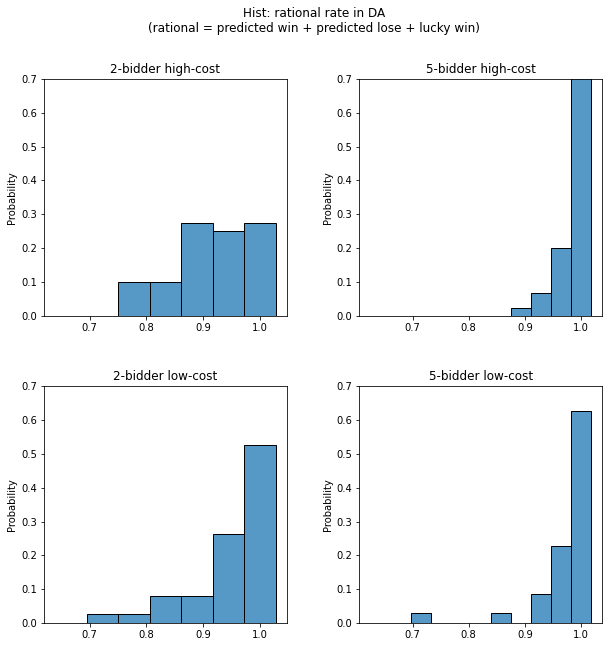

In [11]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

bmin = 18 / 28
bmax = 1
bstep = 1 / 28
# plt.subplot(3, 2, 1)
# tmp = df5["d_n_rational"] / df5["d_n_total"]
# sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
# plt.title("5-bidder all (step=1/28)")
plt.subplot(2, 2, 2)
tmp = df5h["d_n_rational"] / df5h["d_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.7)
plt.title("5-bidder high-cost")
plt.subplot(2, 2, 4)
tmp = df5l["d_n_rational"] / df5l["d_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.7)
plt.title("5-bidder low-cost")

bmin = 12 / 18 
bmax = 1
bstep = 1 / 18
# plt.subplot(3, 2, 2)
# tmp = df2["d_n_rational"] / df2["d_n_total"]
# sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
# plt.title("2-bidder all (step=1/18)")
plt.subplot(2, 2, 1)
tmp = df2h["d_n_rational"] / df2h["d_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.7)
plt.title("2-bidder high-cost")
plt.subplot(2, 2, 3)
tmp = df2l["d_n_rational"] / df2l["d_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.7)
plt.title("2-bidder low-cost")

plt.suptitle("Hist: rational rate in DA\n(rational = predicted win + predicted lose + lucky win)")

Text(0.5, 0.98, 'Hist: rational rate in HA dutch stage\n(rational = predicted win + predicted lose + lucky win)')

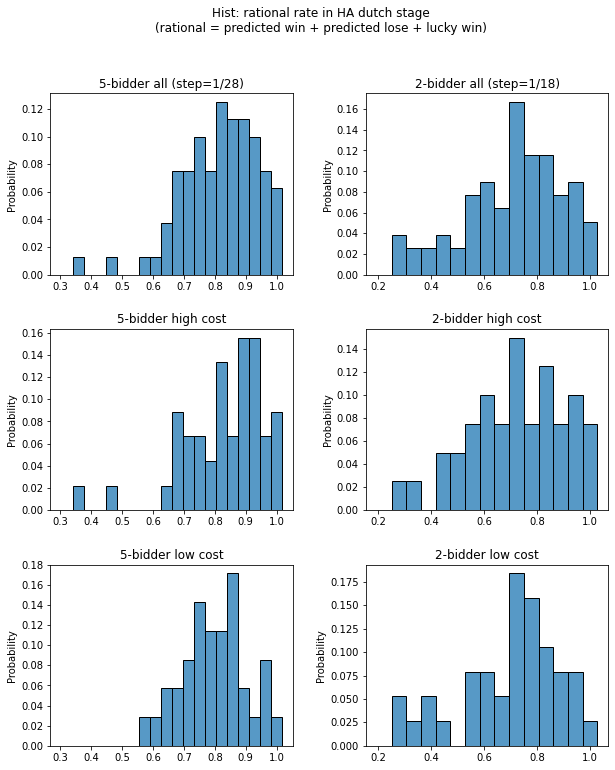

In [63]:
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

bmin = 8 / 28
bmax = 1
bstep = 1 / 28
plt.subplot(3, 2, 1)
tmp = df5["h_n_rational"] / df5["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin + 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("5-bidder all (step=1/28)")
plt.subplot(3, 2, 3)
tmp = df5h["h_n_rational"] / df5h["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin + 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("5-bidder high cost")
plt.subplot(3, 2, 5)
tmp = df5l["h_n_rational"] / df5l["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin + 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("5-bidder low cost")

bmin = 3 / 18
bmax = 1
bstep = 1 / 18
plt.subplot(3, 2, 2)
tmp = df2["h_n_rational"] / df2["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin + 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("2-bidder all (step=1/18)")
plt.subplot(3, 2, 4)
tmp = df2h["h_n_rational"] / df2h["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin + 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("2-bidder high cost")
plt.subplot(3, 2, 6)
tmp = df2l["h_n_rational"] / df2l["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin + 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("2-bidder low cost")

plt.suptitle("Hist: rational rate in HA dutch stage\n(rational = predicted win + predicted lose + lucky win)")

Text(0.5, 0.98, 'Hist: correct rate in HA contest stage\n(correct = correct bid + correct leave)')

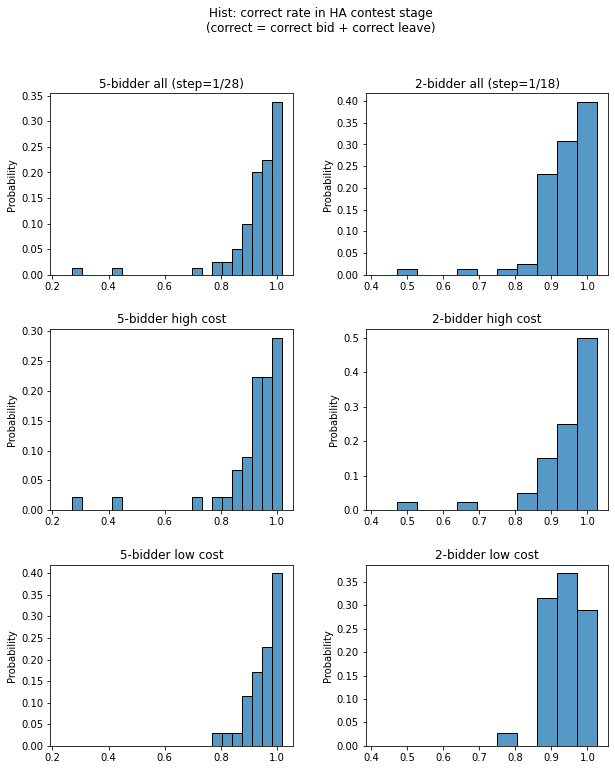

In [64]:
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

bmin = 7 / 28
bmax = 1
bstep = 1 / 28
plt.subplot(3, 2, 1)
tmp = df5["h_n_contest_correct"]  / df5["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("5-bidder all (step=1/28)")
plt.subplot(3, 2, 3)
tmp = df5h["h_n_contest_correct"] / df5h["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("5-bidder high cost")
plt.subplot(3, 2, 5)
tmp = df5l["h_n_contest_correct"] / df5l["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("5-bidder low cost")

bmin = 8 / 18
bmax = 1
bstep = 1 / 18
plt.subplot(3, 2, 2)
tmp = df2["h_n_contest_correct"] / df2["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("2-bidder all (step=1/18)")
plt.subplot(3, 2, 4)
tmp = df2h["h_n_contest_correct"]  / df2h["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("2-bidder high cost")
plt.subplot(3, 2, 6)
tmp = df2l["h_n_contest_correct"] / df2l["h_n_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("2-bidder low cost")

plt.suptitle("Hist: correct rate in HA contest stage\n(correct = correct bid + correct leave)")

Text(0.5, 0.98, 'Hist: correct leave rate in HA english stage\n')

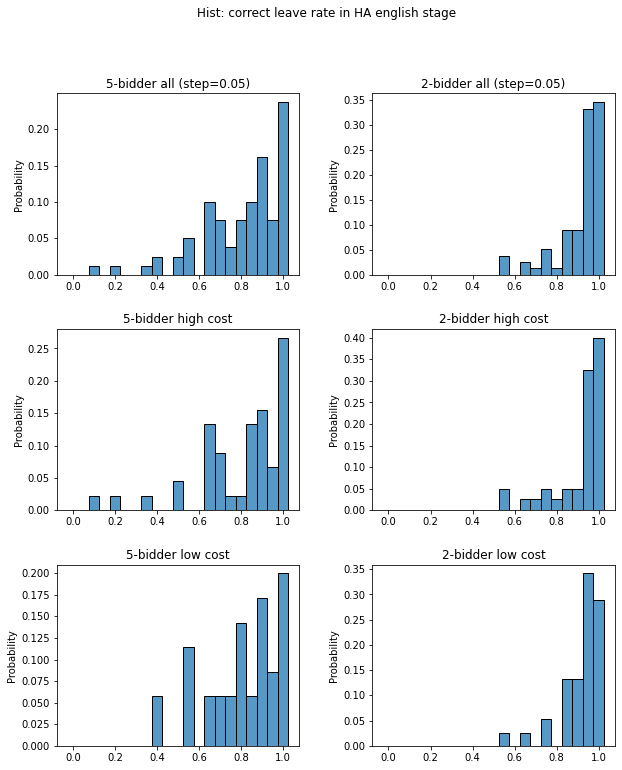

In [65]:
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

bmin = 0
bmax = 1
bstep = 0.05
plt.subplot(3, 2, 1)
tmp = df5["h_n_english_correct"] / df5["h_n_english_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("5-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 3)
tmp = df5h["h_n_english_correct"] / df5h["h_n_english_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("5-bidder high cost")
plt.subplot(3, 2, 5)
tmp = df5l["h_n_english_correct"] / df5l["h_n_english_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("5-bidder low cost")

plt.subplot(3, 2, 2)
tmp = df2["h_n_english_correct"] / df2["h_n_english_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("2-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 4)
tmp = df2h["h_n_english_correct"] / df2h["h_n_english_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("2-bidder high cost")
plt.subplot(3, 2, 6)
tmp = df2l["h_n_english_correct"] / df2l["h_n_english_total"]
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), stat="probability")
plt.title("2-bidder low cost")

plt.suptitle("Hist: correct leave rate in HA english stage\n")

#### Median deviation

In [58]:
df5 = df_stat[df_stat["session_type"].str.contains("05_")]
df5h = df5[df5["session_discount"] == 0.019]
df5l = df5[df5["session_discount"] == 0.009]
df2 = df_stat[df_stat["session_type"].str.contains("02_")]
df2h = df2[df2["session_discount"] == 0.019]
df2l = df2[df2["session_discount"] == 0.009]

Text(0.5, 0.98, 'Hist: median deviation for rational bid in DA\n(prediction - actual)')

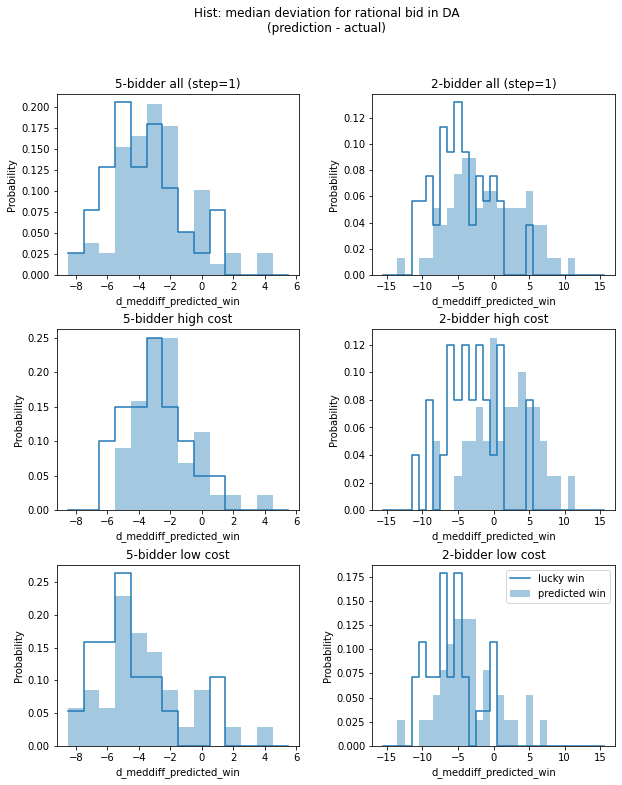

In [67]:
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

bmin = -8
bmax = 5
bstep = 1
plt.subplot(3, 2, 1)
sns.histplot(df5["d_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df5["d_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("5-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 3)
sns.histplot(df5h["d_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df5h["d_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("5-bidder high cost")
plt.subplot(3, 2, 5)
sns.histplot(df5l["d_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df5l["d_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("5-bidder low cost")

bmin = -15
bmax = 15
bstep = 1
plt.subplot(3, 2, 2)
sns.histplot(df2["d_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df2["d_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("2-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 4)
sns.histplot(df2h["d_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df2h["d_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("2-bidder high cost")
plt.subplot(3, 2, 6)
sns.histplot(df2l["d_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df2l["d_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("2-bidder low cost")

plt.legend()
plt.suptitle("Hist: median deviation for rational bid in DA\n(prediction - actual)")

Text(0.5, 0.98, 'Hist: median deviation for correct bid in HA dutch stage\n(prediction - actual)')

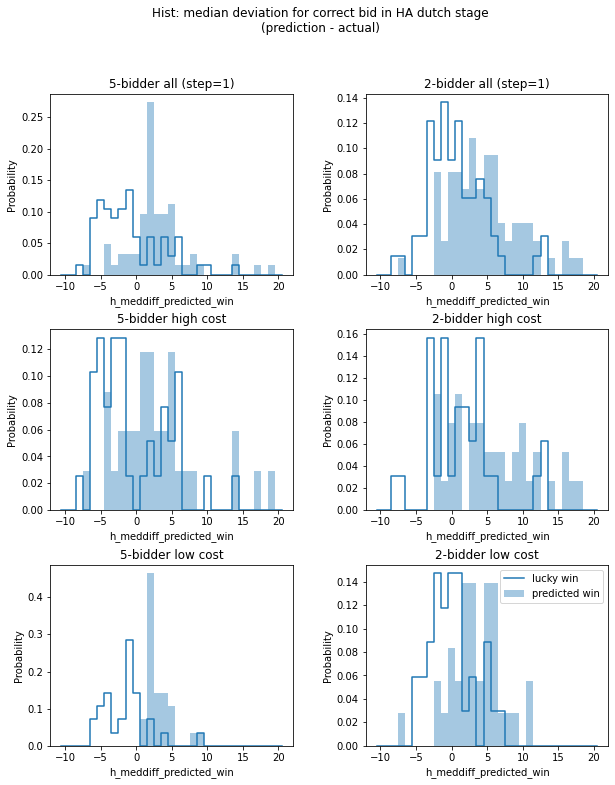

In [68]:
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

bmin = -10
bmax = 20
bstep = 1
plt.subplot(3, 2, 1)
sns.histplot(df5["h_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df5["h_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("5-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 3)
sns.histplot(df5h["h_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df5h["h_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("5-bidder high cost")
plt.subplot(3, 2, 5)
sns.histplot(df5l["h_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df5l["h_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("5-bidder low cost")

bmin = -10
bmax = 20
bstep = 1
plt.subplot(3, 2, 2)
sns.histplot(df2["h_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df2["h_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("2-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 4)
sns.histplot(df2h["h_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df2h["h_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("2-bidder high cost")
plt.subplot(3, 2, 6)
sns.histplot(df2l["h_meddiff_predicted_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", edgecolor=None, alpha=0.4, stat="probability")
sns.histplot(df2l["h_meddiff_lucky_win"], bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("2-bidder low cost")

plt.legend()
plt.suptitle("Hist: median deviation for correct bid in HA dutch stage\n(prediction - actual)")

Text(0.5, 1.0, '2-bidder low-cost')

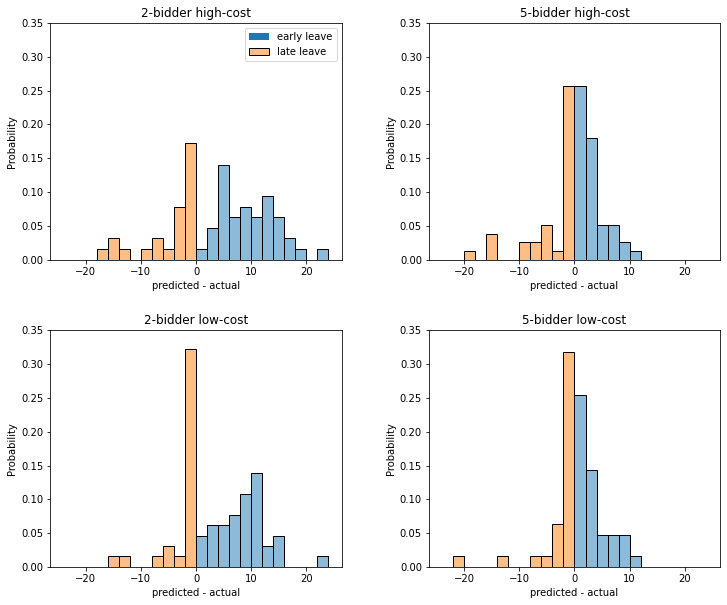

In [66]:
plt.figure(figsize=(12, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

bmin = -24
bmax = 24
bstep = 2

plt.subplot(2, 2, 2)
sns.histplot(df5h[["h_meddiff_english_correct", "h_meddiff_english_irrational"]], bins=np.arange(bmin, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.35)
plt.xlabel("predicted - actual")
plt.legend("", frameon=False)
plt.title("5-bidder high-cost")

plt.subplot(2, 2, 4)
sns.histplot(df5l[["h_meddiff_english_correct", "h_meddiff_english_irrational"]], bins=np.arange(bmin, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.35)
plt.xlabel("predicted - actual")
plt.legend("", frameon=False)
plt.title("5-bidder low-cost")

plt.subplot(2, 2, 1)
sns.histplot(df2h[["h_meddiff_english_correct", "h_meddiff_english_irrational"]], bins=np.arange(bmin, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.35)
plt.xlabel("predicted - actual")
plt.legend(["early leave", "late leave"])
plt.title("2-bidder high-cost")

plt.subplot(2, 2, 3)
sns.histplot(df2l[["h_meddiff_english_correct", "h_meddiff_english_irrational"]], bins=np.arange(bmin, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.35)
plt.xlabel("predicted - actual")
plt.legend("", frameon=False)
plt.title("2-bidder low-cost")

#plt.suptitle("Hist: median deviation for leave price in HA english stage\n(prediction - actual)")

#### Deviation distribution

In [12]:
df5 = df_out[df_out["session_type"].str.contains("05_")]
df5h = df5[df5["session_discount"] == 0.019]
df5l = df5[df5["session_discount"] == 0.009]
df2 = df_out[df_out["session_type"].str.contains("02_")]
df2h = df2[df2["session_discount"] == 0.019]
df2l = df2[df2["session_discount"] == 0.009]

Text(0.5, 0.98, 'Hist: deviation for rational behaviour in DA\n(prediction - actual)')

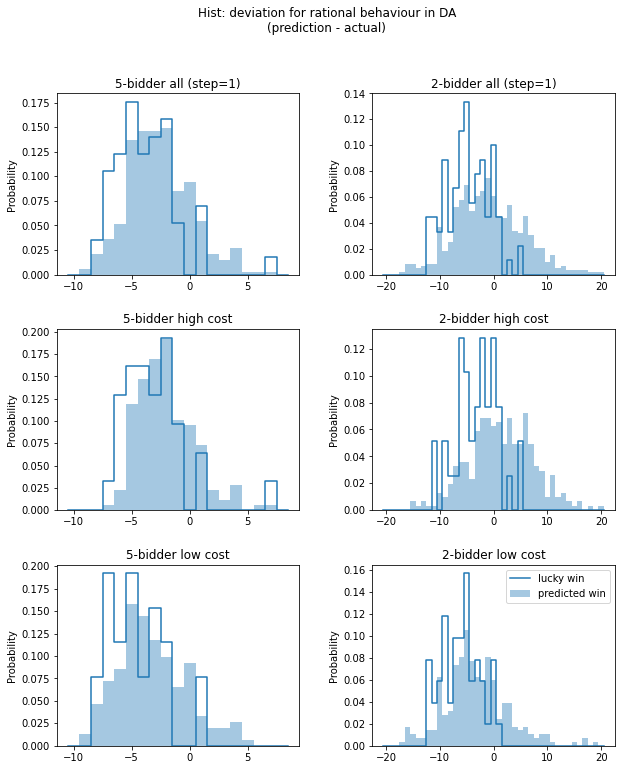

In [20]:
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

bmin = -10
bmax = 8
bstep = 1
plt.subplot(3, 2, 1)
tmp = []
for item in df5["d_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", alpha=0.4, edgecolor=None)
tmp = []
for item in df5["d_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", stat="probability", element="step", fill=False)
plt.title("5-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 3)
tmp = []
for item in df5h["d_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", alpha=0.4, edgecolor=None)
tmp = []
for item in df5h["d_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", stat="probability", element="step", fill=False)
plt.title("5-bidder high cost")
plt.subplot(3, 2, 5)
tmp = []
for item in df5l["d_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", alpha=0.4, edgecolor=None)
tmp = []
for item in df5l["d_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", stat="probability", element="step", fill=False)
plt.title("5-bidder low cost")

bmin = -20
bmax = 20
bstep = 1
plt.subplot(3, 2, 2)
tmp = []
for item in df2["d_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", alpha=0.4, edgecolor=None)
tmp = []
for item in df2["d_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", stat="probability", element="step", fill=False)
plt.title("2-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 4)
tmp = []
for item in df2h["d_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", alpha=0.4, edgecolor=None)
tmp = []
for item in df2h["d_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", stat="probability", element="step", fill=False)
plt.title("2-bidder high cost")
plt.subplot(3, 2, 6)
tmp = []
for item in df2l["d_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", alpha=0.4, edgecolor=None)
tmp = []
for item in df2l["d_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", stat="probability", element="step", fill=False)
plt.title("2-bidder low cost")

plt.legend()
plt.suptitle("Hist: deviation for rational behaviour in DA\n(prediction - actual)")

Text(0.5, 0.98, 'Hist: deviation for rational behaviour in DA\n(prediction - actual)')

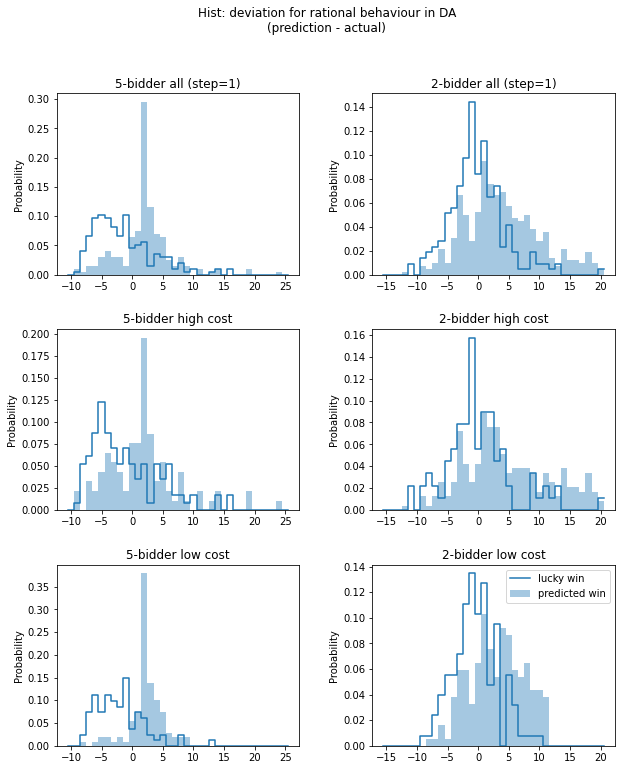

In [21]:
plt.figure(figsize=(10, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

bmin = -10
bmax = 25
bstep = 1
plt.subplot(3, 2, 1)
tmp = []
for item in df5["h_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", edgecolor=None, alpha=0.4)
tmp = []
for item in df5["h_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("5-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 3)
tmp = []
for item in df5h["h_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", edgecolor=None, alpha=0.4)
tmp = []
for item in df5h["h_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("5-bidder high cost")
plt.subplot(3, 2, 5)
tmp = []
for item in df5l["h_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", edgecolor=None, alpha=0.4)
tmp = []
for item in df5l["h_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("5-bidder low cost")

bmin = -15
bmax = 20
bstep = 1
plt.subplot(3, 2, 2)
tmp = []
for item in df2["h_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", edgecolor=None, alpha=0.4)
tmp = []
for item in df2["h_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("2-bidder all (step=%s)" % bstep)
plt.subplot(3, 2, 4)
tmp = []
for item in df2h["h_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", edgecolor=None, alpha=0.4)
tmp = []
for item in df2h["h_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("2-bidder high cost")
plt.subplot(3, 2, 6)
tmp = []
for item in df2l["h_diff_dutch_predicted_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="predicted win", stat="probability", edgecolor=None, alpha=0.4)
tmp = []
for item in df2l["h_diff_dutch_lucky_win"]:
    tmp += item
sns.histplot(tmp, bins=np.arange(bmin - 0.5 * bstep, bmax + bstep, bstep), label="lucky win", element="step", stat="probability", fill=False)
plt.title("2-bidder low cost")

plt.legend()
plt.suptitle("Hist: deviation for rational behaviour in DA\n(prediction - actual)")

Text(0.5, 1.0, '2-bidder low-cost')

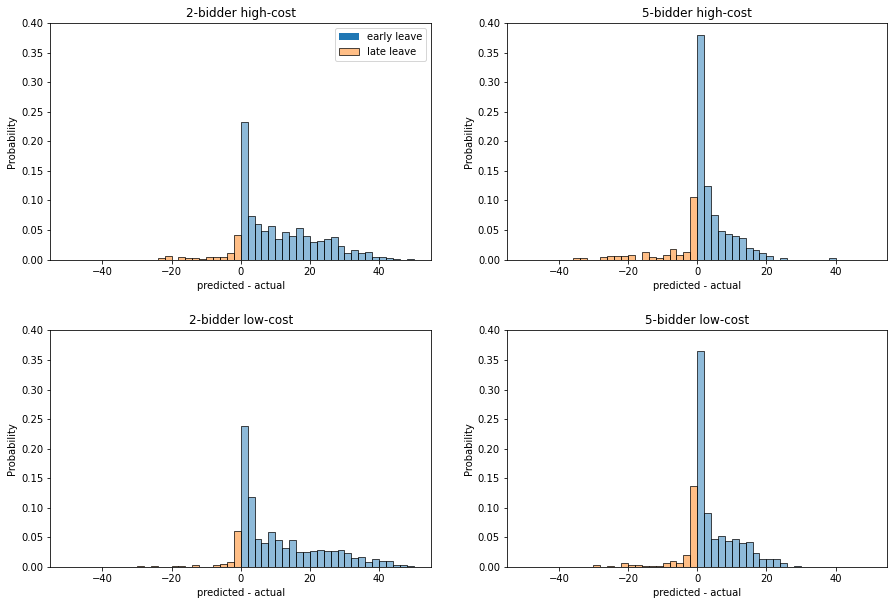

In [56]:
plt.figure(figsize=(15, 10))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

bmin = -50
bmax = 50
bstep = 2

plt.subplot(2, 2, 2)
tmp = {
    "h_diff_english_correct": [],
    "h_diff_english_irrational": [],
}
for item in df5h["h_diff_english_correct"]:
    tmp["h_diff_english_correct"] += item
for item in df5h["h_diff_english_irrational"]:
    tmp["h_diff_english_irrational"] += item
sns.histplot(tmp, bins=np.arange(bmin, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.4)
plt.xlabel("predicted - actual")
plt.legend("", frameon=False)
plt.title("5-bidder high-cost")

plt.subplot(2, 2, 4)
tmp = {
    "h_diff_english_correct": [],
    "h_diff_english_irrational": [],
}
for item in df5l["h_diff_english_correct"]:
    tmp["h_diff_english_correct"] += item
for item in df5l["h_diff_english_irrational"]:
    tmp["h_diff_english_irrational"] += item
sns.histplot(tmp, bins=np.arange(bmin, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.4)
plt.xlabel("predicted - actual")
plt.legend("", frameon=False)
plt.title("5-bidder low-cost")

plt.subplot(2, 2, 1)
tmp = {
    "h_diff_english_correct": [],
    "h_diff_english_irrational": [],
}
for item in df2h["h_diff_english_correct"]:
    tmp["h_diff_english_correct"] += item
for item in df2h["h_diff_english_irrational"]:
    tmp["h_diff_english_irrational"] += item
sns.histplot(tmp, bins=np.arange(bmin, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.4)
plt.xlabel("predicted - actual")
plt.legend(["early leave", "late leave"])
plt.title("2-bidder high-cost")

plt.subplot(2, 2, 3)
tmp = {
    "h_diff_english_correct": [],
    "h_diff_english_irrational": [],
}
for item in df2l["h_diff_english_correct"]:
    tmp["h_diff_english_correct"] += item
for item in df2l["h_diff_english_irrational"]:
    tmp["h_diff_english_irrational"] += item
sns.histplot(tmp, bins=np.arange(bmin, bmax + bstep, bstep), stat="probability")
plt.ylim(0, 0.4)
plt.xlabel("predicted - actual")
plt.legend("", frameon=False)
plt.title("2-bidder low-cost")

# plt.suptitle("Hist: deviation for leave price in HA english stage\n(prediction - actual)")